<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/17_17_RF_32_modelsavefeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import widgets
import os
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from rasterio.windows import Window
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict
from tqdm import tqdm
import time
import warnings

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
zip_path = input("Please paste the path to your zip file from the sidebar: ")
destination = "/content/dataset"

if os.path.exists(zip_path):
    !unzip -q "{zip_path}" -d "{destination}"
    print(f"Successfully unzipped to {destination}")
else:
    print("Error: File path not found. Did you mount your drive?")
drive.mount('/content/drive')

Please paste the path to your zip file from the sidebar: /content/drive/MyDrive/scraghbog.zip
Successfully unzipped to /content/dataset
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
S_RGB_PATH = input("Summer RGB Path: ")
S_NDVI_PATH = input("Summer NDVI Path: ")
S_DSM = input("Summer DSM Path: ")
W_RGB_PATH = input("Winter RGB Path: ")
W_NDVI_PATH = input("Winter NDVI Path: ")
W_DSM = input("Winter DSM Path: ")
SHP_PATH = input("Shapefile (.shp) Path: ")

Summer RGB Path: /content/dataset/scraghbog/scraghbog_rgb_summer.tif
Summer NDVI Path: /content/dataset/scraghbog/Scraghbog_Summer_NDVI.tif
Summer DSM Path: /content/dataset/scraghbog/scraghbog_dem_summer.tif
Winter RGB Path: /content/dataset/scraghbog/Scraghbog_RGB_winter.tif
Winter NDVI Path: /content/dataset/scraghbog/Scraghbog_Winter_NDVI.tif
Winter DSM Path: /content/dataset/scraghbog/Scraghbog_Winter_DSM.tif
Shapefile (.shp) Path: /content/dataset/scraghbog/scraghBog_habiMap.shp


In [6]:
LABEL_COL = 'fid'
NAME_COL = 'HCH_MAPPED'

gdf = gpd.read_file(SHP_PATH)


In [7]:
fossitt_merger = {
    'GS4': 'Grassland',
    'PF1' : 'fen', 'PF3': 'fen',
    'WD4': 'Tree & scrub', 'WN6': 'Tree & scrub', 'WN7': 'Tree & scrub',
    'FS1': 'Swamp/water', 'FS2': 'Swamp/water', 'FW2/WL2': 'Swamp/water'

}
gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

KERNEL = 17


In [8]:
def get_32_features(win_data, res):
    """Calculates 32 features with overflow protection and correct indexing."""
    eps = 1e-7

    # 1. Spectral Extraction
    # RGB means: Axis (1,2) on a (3, 17, 17) array returns [R, G, B]
    s_rgb = np.nanmean(win_data['s_rgb'], axis=(1, 2)).astype('float64')
    w_rgb = np.nanmean(win_data['w_rgb'], axis=(1, 2)).astype('float64')

    # Single band means: Returns scalar
    s_nd = np.clip(np.nanmean(win_data['s_ndvi']), -0.9, 0.9)
    w_nd = np.clip(np.nanmean(win_data['w_ndvi']), -0.9, 0.9)
    s_h = np.nanmean(win_data['s_dsm'])
    w_h = np.nanmean(win_data['w_dsm'])

    # 2. Synthetic NIR
    s_nir = s_rgb[0] * (1 + s_nd) / (1 - s_nd + eps)
    w_nir = w_rgb[0] * (1 + w_nd) / (1 - w_nd + eps)

    # 3. Advanced Indices Helper
    def calc_idx(r, g, b, nir):
        rvi = nir / (r + eps)
        savi = ((nir - r) / (nir + r + 0.5 + eps)) * 1.5
        evi = 2.5 * ((nir - r) / (nir + 6 * r - 7.5 * b + 1 + eps))
        gndvi = (nir - g) / (nir + g + eps)
        grvi = (g - r) / (g + r + eps)
        nrvi = (rvi - 1) / (rvi + 1 + eps)
        ndwi = (g - nir) / (g + nir + eps)
        vari = (g - r) / (g + r - b + eps)
        return np.clip([rvi, savi, evi, gndvi, grvi, nrvi, ndwi, vari], -100, 100)

    s_idx = calc_idx(s_rgb[0], s_rgb[1], s_rgb[2], s_nir)
    w_idx = calc_idx(w_rgb[0], w_rgb[1], w_rgb[2], w_nir)

    # 4. Topography (Micro-structure)
    dsm = win_data['s_dsm'].astype('float64')
    dz_dy, dz_dx = np.gradient(dsm, res)
    slope = np.nanmean(np.degrees(np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))))
    roughness = np.nanstd(dsm)

    # 5. Final Stack
    features = np.concatenate([
        s_rgb, w_rgb,          # 1-6
        [s_nd, w_nd],          # 7-8
        [s_h, w_h],            # 9-10
        [s_nir, w_nir],        # 11-12
        s_idx, w_idx,          # 13-28
        [slope, roughness],    # 29-30
        [s_nd - w_nd],         # 31 (Delta NDVI)
        [s_h - w_h]            # 32 (Delta Height)
    ])
    return np.nan_to_num(features).astype('float32')


In [9]:
##TOO SLOW##

# X_list, y_list = [], []

# with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
#      rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
#      rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

#     res = sd.res[0]
#     gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
#     gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

#     print(f"Extracting 32 features from 1x1m blocks...")
#     for _, row in gdf.iterrows():
#         geom = row.geometry
#         b = geom.bounds
#         r1, c1 = sd.index(b[0], b[3])
#         r2, c2 = sd.index(b[2], b[1])

#         for r in range(r1, r2, KERNEL):
#             for c in range(c1, c2, KERNEL):
#                 win = Window(c, r, KERNEL, KERNEL)

#                 # Verify point is inside polygon
#                 center_pt = sd.xy(r + KERNEL//2, c + KERNEL//2)
#                 if not Point(center_pt).within(geom): continue

#                 data = {
#                     's_rgb': sr.read(window=win, boundless=True, fill_value=0),
#                     's_ndvi': sn.read(1, window=win, boundless=True, fill_value=0),
#                     's_dsm': sd.read(1, window=win, boundless=True, fill_value=0),
#                     'w_rgb': wr.read(window=win, boundless=True, fill_value=0),
#                     'w_ndvi': wn.read(1, window=win, boundless=True, fill_value=0),
#                     'w_dsm': wd.read(1, window=win, boundless=True, fill_value=0)
#                 }

#                 if np.max(data['s_rgb']) > 0:
#                     try:
#                         X_list.append(get_32_features(data, res))
#                         y_list.append(row['merged_name'])
#                     except: continue

# X, y = np.array(X_list), np.array(y_list)
# print(f"Dataset extracted: {len(X)} objects.")

In [10]:
import time
from tqdm import tqdm

X_list, y_list = [], []
start_time = time.time()

# 1. Open all files
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    res = sd.res[0]
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print(f"Starting Polygon-Chunked Extraction on {len(gdf)} polygons...")

    for _, row in tqdm(gdf.iterrows(), total=gdf.shape[0], desc="Polygons"):
        geom = row.geometry
        # Define the window for this specific polygon
        poly_window = rasterio.windows.from_bounds(*geom.bounds, transform=sd.transform)

        # Round the window to integer offsets to avoid slice errors
        poly_window = poly_window.round_offsets().round_shape()

        # --- THE SPEED SECRET: Read the whole polygon area into RAM ONCE ---
        try:
            s_rgb_p = sr.read(window=poly_window)
            s_nd_p  = sn.read(1, window=poly_window)
            s_dsm_p = sd.read(1, window=poly_window)
            w_rgb_p = wr.read(window=poly_window)
            w_nd_p  = wn.read(1, window=poly_window)
            w_dsm_p = wd.read(1, window=poly_window)
        except Exception as e:
            # Skip if window is invalid or outside raster bounds
            continue

        # Get local dimensions of this polygon chunk
        p_rows, p_cols = s_nd_p.shape
        # Create a transform local to this chunk for spatial checking
        chunk_transform = rasterio.windows.transform(poly_window, sd.transform)

        # Slice the RAM arrays
        for r in range(0, p_rows - KERNEL, KERNEL):
            for c in range(0, p_cols - KERNEL, KERNEL):

                # Spatial check using center point
                center_coords = chunk_transform * (c + KERNEL//2, r + KERNEL//2)

                if Point(center_coords).within(geom):
                    # Slice from the data already in RAM
                    data = {
                        's_rgb': s_rgb_p[:, r:r+KERNEL, c:c+KERNEL],
                        's_ndvi': s_nd_p[r:r+KERNEL, c:c+KERNEL],
                        's_dsm': s_dsm_p[r:r+KERNEL, c:c+KERNEL],
                        'w_rgb': w_rgb_p[:, r:r+KERNEL, c:c+KERNEL],
                        'w_ndvi': w_nd_p[r:r+KERNEL, c:c+KERNEL],
                        'w_dsm': w_dsm_p[r:r+KERNEL, c:c+KERNEL]
                    }

                    if np.max(data['s_rgb']) > 0:
                        try:
                            # Calculate features using CPU (very fast)
                            X_list.append(get_32_features(data, res))
                            y_list.append(row['merged_name'])
                        except:
                            continue

X, y = np.array(X_list), np.array(y_list)
print(f"\nExtraction complete: {len(X)} objects in {round((time.time()-start_time)/60, 2)}m")

Starting Polygon-Chunked Extraction on 18 polygons...


Polygons:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/windows.py:729: RasterioDeprecationWarning: round_shape is deprecated and will be removed in Rasterio 2.0.0.
  warnings.warn(
Polygons:   6%|▌         | 1/18 [00:08<02:23,  8.46s/it]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Polygons:  11%|█         | 2/18 [00:21<03:01, 11.32s/it]/tmp/ipython-input-281368244.py:12: RuntimeWarning: Mean of empty slice
  w_nd = np.clip(np.nanmean(win_data['w_ndvi']), -0.9, 0.9)
Polygons: 100%|██████████| 18/18 [08:47<00:00, 29.30s/it]



Extraction complete: 446859 objects in 8.8m


In [15]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1)
# y_pred = cross_val_predict(rf, X, y, cv=kf)

# print("\n--- 32-FEATURE K-FOLD REPORT ---")
# print(classification_report(y, y_pred))

# # Train final model
# rf.fit(X, y)

In [12]:
# from sklearn.model_selection import StratifiedKFold, cross_val_predict

# # 1. Lower tree count and add depth limits for speed
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# rf = RandomForestClassifier(
#     n_estimators=100,      # Dropped from 700
#     max_depth=20,          # Prevents endless branching
#     min_samples_leaf=20,   # Stops overfitting on large data
#     class_weight='balanced',
#     n_jobs=-1
# )

# # 2. Run the cross-validation
# y_pred = cross_val_predict(rf, X, y, cv=kf, n_jobs=-1)

# print("\n--- 32-FEATURE K-FOLD REPORT ---")
# print(classification_report(y, y_pred))

# # 3. Train final model
# rf.fit(X, y)

KeyboardInterrupt: 

In [16]:
# This uses your 500 trees and sqrt(M) but adds speed optimizations
rf = RandomForestClassifier(
    n_estimators=500,
    max_features='sqrt',      # This is your M_var = sqrt(M)
    max_samples=0.2,          # MASSIVE speed boost: each tree sees 20% of data
    max_depth=20,             # Prevents trees from becoming infinitely deep
    class_weight='balanced',
    n_jobs=-1                 # Uses all your CPU cores
)

In [17]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report

# Use StratifiedKFold to maintain class ratios across folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Starting Cross-Validation on {X.shape[0]} samples...")

# Generate predictions
# We use n_jobs=1 here because the RF itself is already using n_jobs=-1
y_pred = cross_val_predict(rf, X, y, cv=kf)

print("\n--- 32-FEATURE K-FOLD REPORT ---")
print(classification_report(y, y_pred))

# Train the final model on the entire dataset
print("Training final model...")
rf.fit(X, y)
print("Model training complete!")

Starting Cross-Validation on 446859 samples...

--- 32-FEATURE K-FOLD REPORT ---
              precision    recall  f1-score   support

   Grassland       0.93      0.89      0.91     10107
 Swamp/water       0.87      0.85      0.86     86855
Tree & scrub       0.88      0.87      0.88     40737
         fen       0.95      0.95      0.95    309160

    accuracy                           0.93    446859
   macro avg       0.91      0.89      0.90    446859
weighted avg       0.92      0.93      0.93    446859

Training final model...
Model training complete!


In [18]:
import joblib

# This saves it to the main folder of your Google Drive
# You can change 'My Drive/land_cover_model.pkl' to include a specific folder if you want
path = '/content/drive/My Drive/rf_model.pkl'

joblib.dump(rf, path)

print(f"Success! Your model is now safely stored in your Google Drive at: {path}")

Success! Your model is now safely stored in your Google Drive at: /content/drive/My Drive/rf_model.pkl


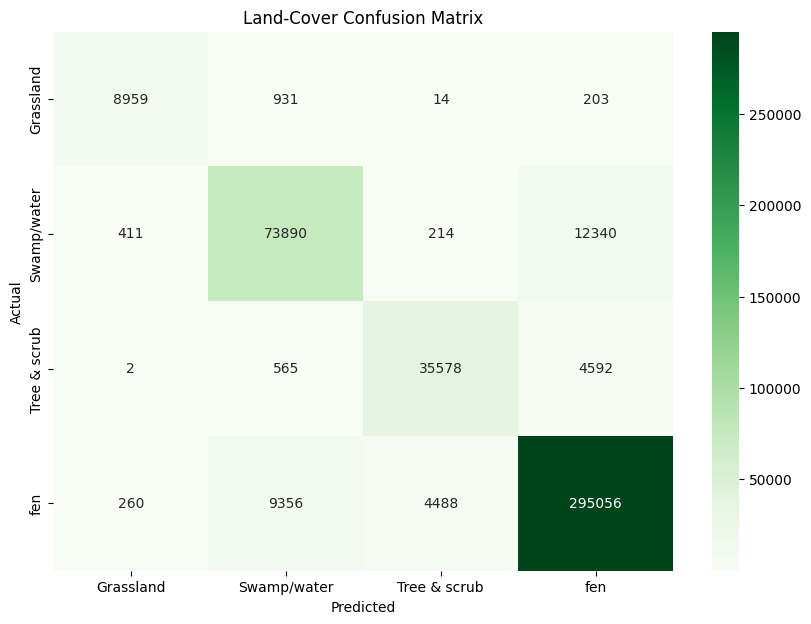

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Create the matrix
cm = confusion_matrix(y, y_pred)
labels = ['Grassland', 'Swamp/water', 'Tree & scrub', 'fen']

# 2. Plot it
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Land-Cover Confusion Matrix')
plt.show()

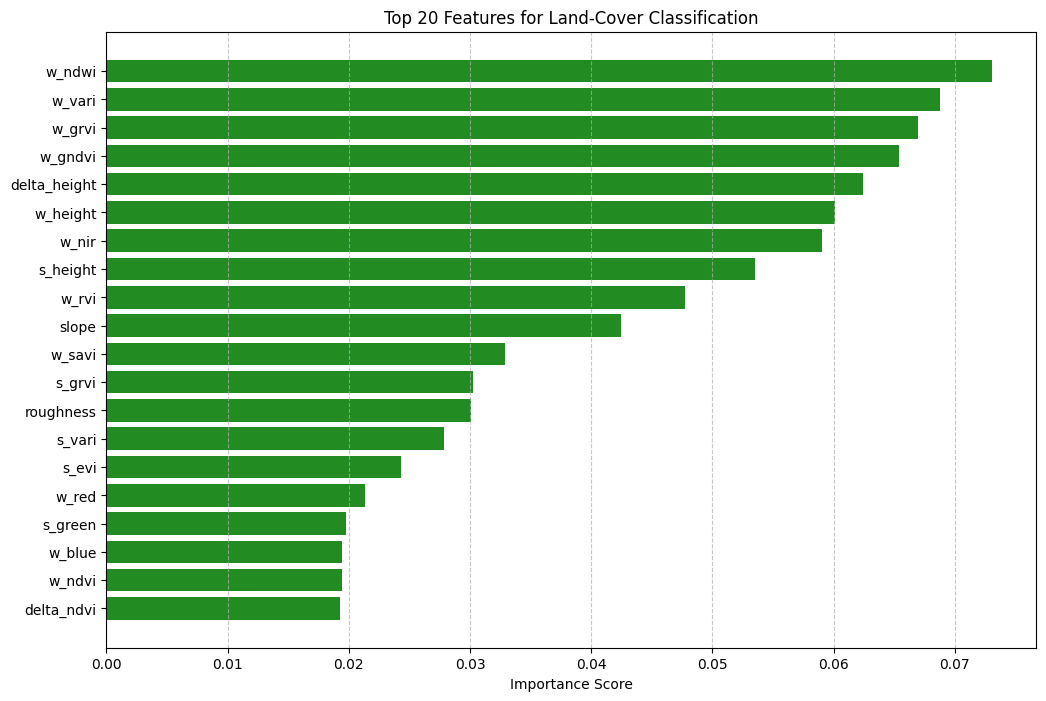

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get the importances from your trained model
importances = rf.feature_importances_

# 2. Use the list from above
feature_names = [
    "s_red", "s_green", "s_blue", "w_red", "w_green", "w_blue",
    "s_ndvi", "w_ndvi", "s_height", "w_height", "s_nir", "w_nir",
    "s_rvi", "s_savi", "s_evi", "s_gndvi", "s_grvi", "s_nrvi", "s_ndwi", "s_vari",
    "w_rvi", "w_savi", "w_evi", "w_gndvi", "w_grvi", "w_nrvi", "w_ndwi", "w_vari",
    "slope", "roughness", "delta_ndvi", "delta_height"
]

# 3. Create DataFrame and Plot
feat_import_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_import_df = feat_import_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
# Showing top 20 for better visibility
plt.barh(feat_import_df['Feature'][:20], feat_import_df['Importance'][:20], color='forestgreen')
plt.gca().invert_yaxis()
plt.title('Top 20 Features for Land-Cover Classification')
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [24]:
print("Generating Habitat Map...")
with rasterio.open(S_RGB_PATH) as sr:
    meta = sr.meta.copy()
    meta.update(count=1, dtype='uint8', nodata=0)
    c_map = {name: i+1 for i, name in enumerate(rf.classes_)}
    with rasterio.open('scraghbog_habitats.tif', 'w', **meta) as dst:
        for r in range(0, sr.height, KERNEL):
            for c in range(0, sr.width, KERNEL):
                win = Window(c, r, KERNEL, KERNEL)
                try:
                    p_data = {'s_rgb': sr.read(window=win), 's_ndvi': sn.read(1, window=win), 's_dsm': sd.read(1, window=win),
                              'w_rgb': wr.read(window=win), 'w_ndvi': wn.read(1, window=win), 'w_dsm': wd.read(1, window=win)}
                    if np.max(p_data['s_rgb']) > 0:
                        dst.write(np.full((KERNEL, KERNEL), c_map[rf.predict(get_32_features(p_data, res).reshape(1, -1))[0]], dtype='uint8'), 1, window=win)
                except: continue
print("Success! Map saved.")

Generating Habitat Map...
Success! Map saved.


In [ ]:
# import rasterio
# import matplotlib.pyplot as plt
# import numpy as np

# with rasterio.open('scraghbog_habitats.tif') as m:
#     # Instead of reading everything, we read at 1/10th scale
#     # out_shape calculates a smaller version of the image
#     out_shape = (m.count, int(m.height / 10), int(m.width / 10))

#     data = m.read(
#         1,
#         out_shape=out_shape,
#         resampling=rasterio.enums.Resampling.nearest
#     )

#     # Mask out the background (0)
#     masked_map = np.ma.masked_where(data == 0, data)

#     plt.figure(figsize=(12, 10))
#     # Use 'tab10' or 'Set1' for distinct categorical colors
#     plt.imshow(masked_map, cmap='tab10')
#     plt.title("Habitat Map Preview (Downsampled)")
#     plt.colorbar(ticks=range(1, 6), label="Class ID")
#     plt.show()

In [4]:
import joblib
# Make sure the file path matches where you saved it (e.g., in Drive)
rf = joblib.load('/content/drive/MyDrive/rf_model.pkl')